In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, math
import sklearn.mixture as mixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from skimage import feature

In [3]:
# detect face helper
face_front = cv2.CascadeClassifier( './face_detection_classifier/haarcascade_profileface_cuda.xml')


In [4]:
class Image:
    def __init__(self, image_gray):
        self.image_gray = image_gray
        self.face = []
        self.keypoints = []
        self.descriptors = []
        self.histogram = []

In [5]:
# takes input of the path to the training images, returns list of gray scaled images and name
def load_images(image_path):
    # get all train images name
    train_dataset = os.listdir(image_path)
    images_name = [img_name for img_name in train_dataset if img_name.endswith('.png')]
    images_name.sort()
    images = []
    # read all train images
    for image_name in images_name:
        img_gray = cv2.imread(image_path + image_name, cv2.IMREAD_GRAYSCALE)
        image = Image(img_gray)
        images.append(image)
    return images

In [6]:
class Person:
    def __init__(self, name, train_image_path, test_image_path):
        self.name = name
        self.train_image_path = train_image_path
        self.test_image_path = test_image_path
        # train_images takes a list of Image object
        self.train_images = load_images(train_image_path)
        self.test_images = load_images(test_image_path)
    def append_train_image(self, train_image):
        self.train_images.append(train_image)
    def append_test_image(self, test_image):
        self.test_images.append(test_image)

In [7]:
lily = Person("Lily", './dataset/LILY_TRAIN/', './dataset/LILY_TEST/')
mai = Person("Mai", './dataset/MAI_TRAIN/', './dataset/MAI_TEST/')
jacob = Person("Jacob", './dataset/JACOB_TRAIN/', './dataset/JACOB_TEST/')
awais = Person("Awais", './dataset/AWAIS_TRAIN/', './dataset/AWAIS_TEST/')
swaroop = Person("SWAROOP", './dataset/SWAROOP_TRAIN/', './dataset/SWAROOP_TRAIN/')

In [8]:
# takes an image as input, find the face on the image, and the keypoints in the face bounding box
# add all the keypoints to the image object
def find_keypoints_on_face(image):
    img = image.image_gray
    # check for face two times to ensure the output are all faces
#     face = face_front.detectMultiScale(img, scaleFactor=1.00154, minNeighbors=6)
#     if len(face) == 0 :
# #         face = face_front.detectMultiScale(img, scaleFactor=1.0015, minNeighbors=7)
# #         x, y, w, h = face[-1]
# #         face_extract = img[y-5:y+h+10, x-5:x+w+10]
# #         face_extract = cv2.resize(face_extract, size) 
# #         faces.append(face[-1])
# #         continue
#         print("no face found")
#         return 
#     if len(face) == 0:
    x = 50
    y = 50
    w = 150
    h = 150 
#     else:   
#         x, y, w, h = face[0] # we know that there is only one face per training sample.
   
     # create a mask image filled with zeros, the size of original image
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    # draw your selected ROI on the mask image
    cv2.rectangle(mask, (x,y), (x+w,y+h), (255), thickness = -1)
    sift = cv2.xfeatures2d.SIFT_create()
    # provide mask to the detect method
    kp = sift.detect(img, mask)
    image.keypoints = kp
    

In [9]:
#takes list of images, compute hog features and output the list of features
def HoG(images, cell):
    cell_size = (cell, cell)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins
    features = []
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to multiple of the cell size
        # all arguments should be given in terms of number of pixels
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                          img.shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

        # Compute HoG features
        hog_feats = hog.compute(img)
        hog_feats = hog_feats.flatten()
        features.append(hog_feats)
    features=np.array(features)
    return features

In [10]:
def HOG_DESCRIPTOR(image, cell, patch_size, harris):
    img = image.image_gray
    if harris == 1:
        img = image.face
    kp = image.keypoints
    patches = []
    offset = int(patch_size/2)
    for key in kp:
        x = int(key.pt[0] - offset);
        y = int(key.pt[1] - offset);
        roi = img[y:y+patch_size, x:x+patch_size]
        if(roi.shape[0] == patch_size and roi.shape[1] == patch_size):
            patches.append(roi)
    patches = np.array(patches)
    
    descriptors = HoG(patches, cell)
    image.descriptors = descriptors

In [11]:
def build_vocabulary(cell_size, patch_size, descriptor, find_keypoints, harris):
    descriptors = []
    for person in members:
        for train_image in person.train_images:
            find_keypoints(train_image)
            descriptor(train_image, cell_size, patch_size, harris)
            descriptors.extend(train_image.descriptors)

    k = int(len(descriptors)/5)
    gmm = mixture.GaussianMixture(covariance_type='full', n_components=k)
    gmm.fit(descriptors)
    return gmm, k

In [12]:
def build_histogram(image, gmm, k):
    if(len(image.descriptors) == 0):
        image.histogram = []
    else:
        predict_labels = gmm.predict(image.descriptors)
        hist = np.histogram(predict_labels, range=(0,k+1), density=True)
        image.histogram = hist[0]

In [13]:
def LBP(images, radius):
    P = 8 * radius
    R = radius
    features = []
    eps = 1e-7
    for img in images:
        lbp = feature.local_binary_pattern(img, P, R)
        (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, P + 3),range=(0, P + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        if np.isnan(hist.any()):
            print("nan")
        
        features.append(hist)
    features=np.array(features)
    return features

In [14]:
# compute lbp descriptors for each patch in the image,
def LBP_DESCRIPTOR(image, radius, patch_size, harris=0):
    img = image.image_gray
    if harris == 1:
        img = image.face
    kp = image.keypoints
    offset = int(patch_size/2)
    patches = []
    for key in kp:
        x = int(key.pt[0] - offset);
        y = int(key.pt[1] - offset);
        roi = img[y:y+patch_size, x:x+patch_size]
        if(roi.shape[0] == patch_size and roi.shape[1] == patch_size):
            patches.append(roi)
    patches = np.array(patches)
    descriptors = LBP(patches, radius)
    image.descriptors = descriptors

In [15]:
# build vocabularies from training images
# label test images based on the descriptors
# input: 
# feature_type: array of 2 elements, first element: function to get BOW histogram
#            second element: cell size or radius size
# patch_size: default to 15
# keypoint_extraction: method to extract keypoints, default to sift keypoints
# members: array of person 
def classify_test_images(feature_type, members, descriptor = HOG_DESCRIPTOR, patch_size = 15, keypoint_extration = find_keypoints_on_face, harris = 0):
    param = feature_type
    train_histograms = []
    train_labels = []
    test_histograms = []
    test_labels = []
#     # build vocabularies for each person's train and test images
    gmm, k = build_vocabulary(param, patch_size, descriptor, keypoint_extration, harris)
    #compute histograms of both training images and testing images
    for index, person in enumerate(members):
        for train_image in person.train_images:
            build_histogram(train_image, gmm, k)
            if(len(train_image.histogram) != 0):   
                train_histograms.append(train_image.histogram)
                train_labels.append(index)
        for test_image in person.test_images:
            keypoint_extration(test_image)
            descriptor(test_image, param, patch_size, harris)
            build_histogram(test_image, gmm, k)
            if(len(test_image.histogram) != 0):
                test_histograms.append(test_image.histogram)
                test_labels.append(index)
            
    print(len(train_histograms))
    print(train_labels)
    print(len(test_histograms))
    print(test_labels)
    #knearest-neighbor classifier
    model = KNeighborsClassifier(n_neighbors=5)
    # Train the model using the training sets
    model.fit(train_histograms, train_labels)
    prediction=[]
    for test in test_histograms:
        predicted= model.predict([test])
        prediction.append(predicted[0])
    print(prediction)
    print(test_labels)
    accuracy_rate = accuracy_score(test_labels, prediction)
    print(accuracy_rate)
    conf_matrix = confusion_matrix(test_labels, prediction)
    plt.imshow(conf_matrix)
    plt.show()
    return accuracy_rate

77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
68
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 0, 0, 0, 2, 0, 0, 0, 1, 3, 3, 3, 0, 3, 3, 0, 2, 0, 3, 3, 3, 2, 0, 3, 0, 0, 0, 1, 0, 3, 3, 3, 3, 2, 2, 0, 3, 2, 2, 3, 0, 3, 0, 0, 3, 0, 3, 0, 0, 2, 0, 0, 3, 3, 2, 4, 2, 4, 1, 4, 1, 4, 4, 1, 1, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.3382352941176471


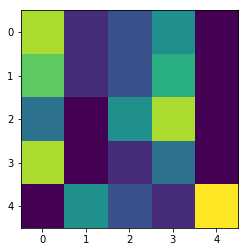

77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
68
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 1, 0, 1, 2, 2, 0, 2, 1, 4, 1, 1, 0, 2, 0, 1, 0, 0, 4, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 3, 1, 0, 2, 2, 4, 2, 4, 2, 2, 2, 0, 3, 2, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.19117647058823528


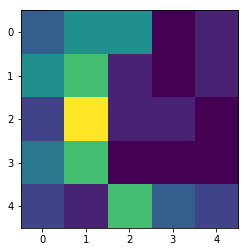

77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
68
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[1, 4, 3, 0, 0, 3, 2, 0, 2, 2, 3, 3, 2, 0, 0, 3, 0, 0, 3, 2, 0, 0, 1, 0, 3, 1, 0, 1, 3, 0, 3, 3, 3, 0, 1, 2, 2, 3, 0, 3, 3, 0, 3, 3, 1, 1, 4, 2, 3, 0, 2, 3, 1, 2, 2, 2, 1, 3, 1, 2, 1, 0, 2, 4, 4, 1, 1, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.22058823529411764


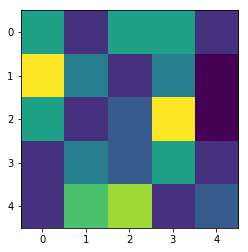

In [15]:
# use HOG descriptors
members=[lily, mai, jacob, awais, swaroop]
# varying cell size for computing hog descriptors

cell_size = [3, 4, 5]
patch_size = 15
accuracy_rates = []
for cell in cell_size:
    accuracy_rate = classify_test_images(cell, members)
    accuracy_rates.append(accuracy_rate)

    


[0.3382352941176471, 0.19117647058823528, 0.22058823529411764]


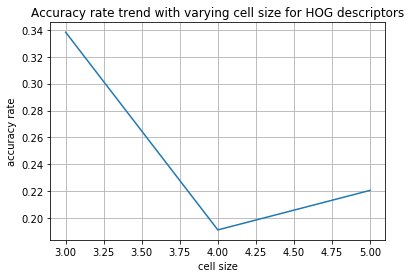

In [16]:
print(accuracy_rates)
fig, ax = plt.subplots()
ax.plot(cell_size, accuracy_rates)
ax.set(xlabel='cell size', ylabel='accuracy rate',
       title='Accuracy rate trend with varying cell size for HOG descriptors')
ax.grid()
plt.show()

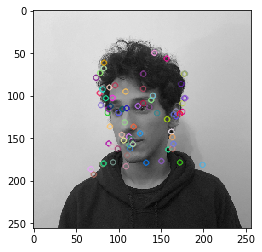

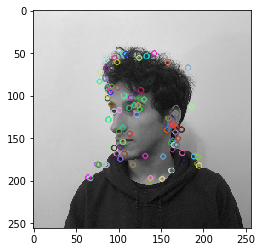

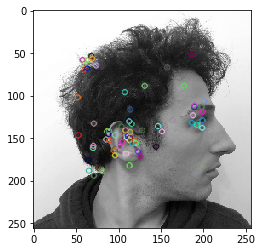

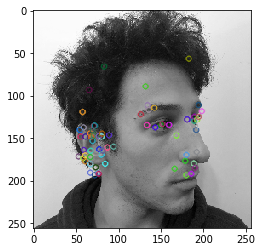

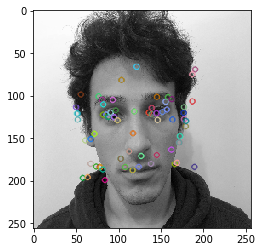

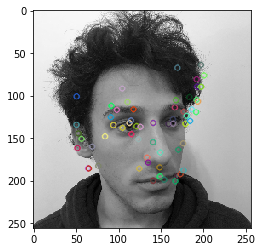

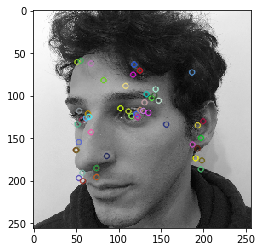

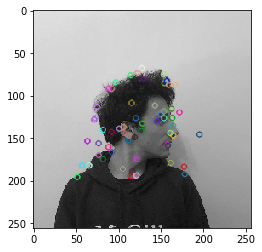

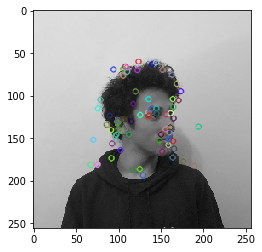

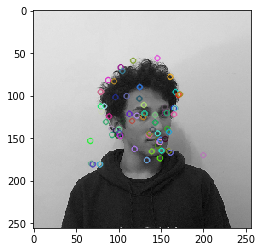

In [17]:
# display keypoints on 10 selected training images
for i in range(10):
    train_image = jacob.train_images[i]
    img_copy = train_image.image_gray.copy()
    img_keypoints=cv2.drawKeypoints(img_copy,train_image.keypoints,img_copy)
    plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
    plt.show()

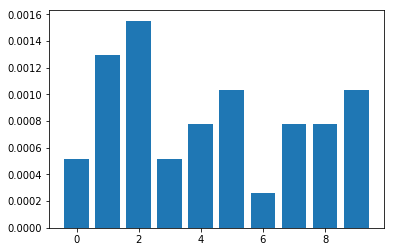

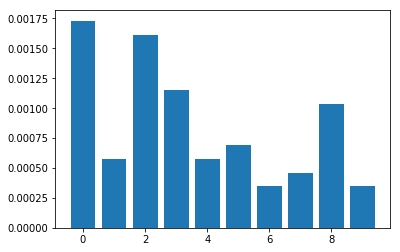

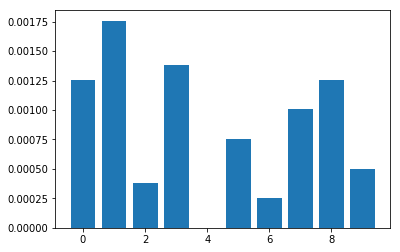

1170


In [21]:
# display histograms for 3 selected training images
for i in range(3):
    train_image = lily.train_images[i]
    k = len(train_image.histogram)
    plt.bar(range(k), train_image.histogram)
    plt.show() 
print(len(gmm.weights_))

77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
68
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 2, 4, 1, 2, 2, 0, 0, 2, 2, 2, 2, 3, 1, 1, 2, 2, 2, 4, 0, 0, 4, 4, 1, 4, 1, 4, 4, 1, 2, 1, 4, 2, 0, 1, 1, 2, 2, 0, 2, 4, 0, 2, 0, 4, 2, 2, 2, 2, 1, 0, 2, 1, 4, 2, 1, 2, 2, 4, 2, 2, 4, 3, 2, 4, 2, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.20588235294117646


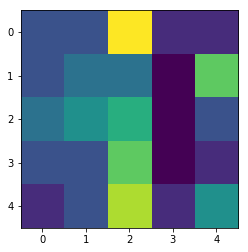

77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
68
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 3, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 4, 2, 2, 4, 2, 3, 0, 1, 2, 4, 0, 1, 4, 3, 3, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.36764705882352944


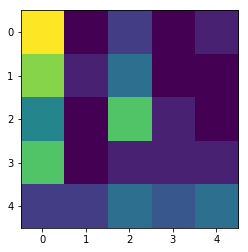

77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
68
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 2, 0, 2, 0, 3, 3, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 1, 2, 3, 1, 1, 2, 0, 1, 2, 2, 0, 2, 4, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 3, 2, 1, 2, 2, 1, 0, 2, 3, 2, 4, 4, 3, 1, 1, 0, 3, 4, 2, 2, 0, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.23529411764705882


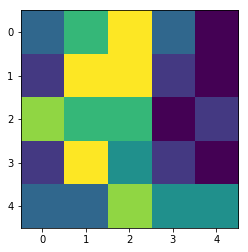

In [19]:
radius = [2,7,12]
patch_size = 15
accuracy_rates = []
for r in radius:
    accuracy_rate = classify_test_images(r, members, LBP_DESCRIPTOR)
    accuracy_rates.append(accuracy_rate)
    

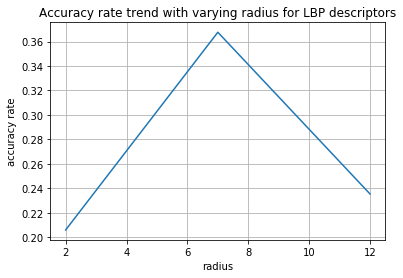

In [20]:
fig, ax = plt.subplots()
ax.plot(radius, accuracy_rates)
ax.set(xlabel='radius', ylabel='accuracy rate',
       title='Accuracy rate trend with varying radius for LBP descriptors')
ax.grid()
plt.show()

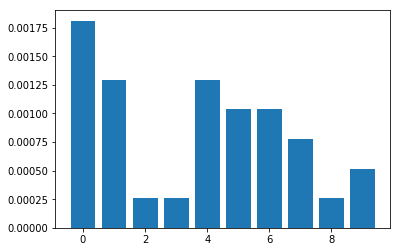

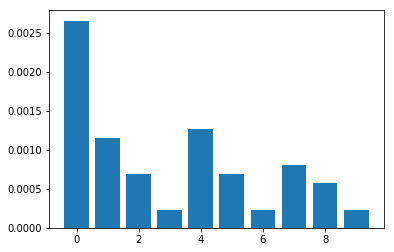

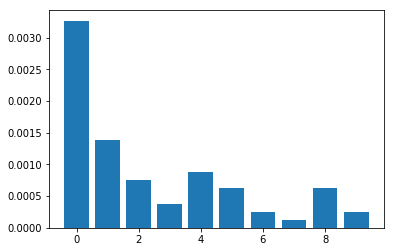

In [24]:
# display histograms for 3 selected training images
for i in range(3):
    train_image = lily.train_images[i]
    k = len(train_image.histogram)
    plt.bar(range(k), train_image.histogram)
    plt.show()

/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (1170). Possibly due to duplicate points in X.
  return_n_iter=True)


77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
68
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.20588235294117646


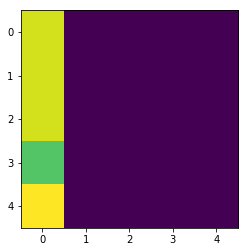

77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
68
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 4, 0, 0, 2, 2, 0, 4, 2, 4, 2, 2, 2, 2, 4, 4, 0, 2, 2, 2, 0, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 0, 2, 3, 1, 1, 2, 4, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.2647058823529412


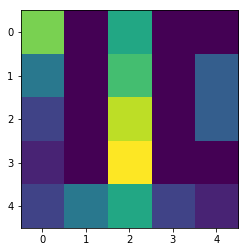

77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
68
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 2, 2, 3, 1, 0, 0, 0, 2, 0, 0, 3, 1, 0, 0, 4, 3, 4, 4, 0, 0, 0, 3, 2, 2, 2, 2, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.35294117647058826


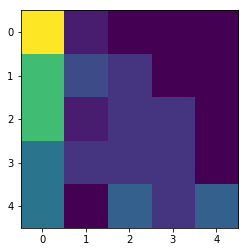

In [22]:
patch_size = [5,15,25]
accuracy_rates = []
for patch in patch_size:
    accuracy_rate = classify_test_images(7, members, LBP_DESCRIPTOR, patch)
    accuracy_rates.append(accuracy_rate)
    

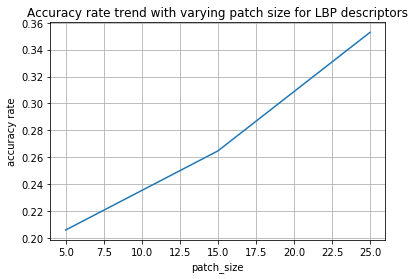

In [24]:
fig, ax = plt.subplots()
ax.plot(patch_size, accuracy_rates)
ax.set(xlabel='patch_size', ylabel='accuracy rate',
       title='Accuracy rate trend with varying patch size for LBP descriptors')
ax.grid()
plt.show()

In [25]:
def find_harris_corner_keypoints(image):
    img = image.image_gray
    # check for face two times to ensure the output are all faces
#     face = face_front.detectMultiScale(img, scaleFactor=1.00154, minNeighbors=6)
#     if len(face) == 0 :
# #         face = face_front.detectMultiScale(img, scaleFactor=1.0015, minNeighbors=7)
# #         x, y, w, h = face[-1]
# #         face_extract = img[y-5:y+h+10, x-5:x+w+10]
# #         face_extract = cv2.resize(face_extract, size) 
# #         faces.append(face[-1])
# #         continue
#         print("no face found")
#         return 
#     x, y, w, h = face[0] # we know that there is only one face per training sample.
    x = 50
    y = 50
    w = 150
    h = 150
    image.face = img[y:y+h, x:x+w]
    # detect harris corners
    # cv2.cornerHarris(src, neighborhoodsize, sobelKernelSize, Harris_k)
    corners = cv2.cornerHarris(image.face, 2, 3, 0.04)

    # normalize corner map [0,1]
    # cv2.normalize(src, dst, alpha, beta, norm_type)
    # min_I(dst(I)) = alpha, max_I(dst(I)) = beta
    cv2.normalize(corners, corners, 0, 1, cv2.NORM_MINMAX)

    # threshold for an optimal value
    thres = 0.85

    # list all points higher than threshold
    loc = np.where(corners >= thres)
    kp = []
    for pt in zip(*loc[::-1]):
        keypoint = cv2.KeyPoint(pt[0], pt[1], 2)
        kp.append(keypoint)
    image.keypoints = kp

66
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
63
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 2, 2, 1, 2, 2, 2, 2, 0, 3, 2, 0, 2, 2, 1, 0, 3, 3, 2, 2, 2, 2, 2, 2, 0, 3, 1, 2, 0, 2, 2, 0, 2, 3, 3, 3, 3, 3, 3, 1, 2, 0, 2, 0, 2, 0, 2, 2, 0, 4, 4, 0, 0, 4, 4, 3, 4, 0, 4, 0, 4, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
0.20634920634920634


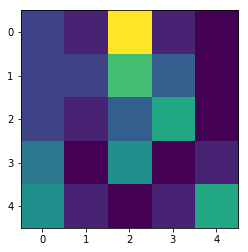

In [26]:
# use harris corner keypoints 
radius = 7
patch_size = 15

accuracy_rate = classify_test_images(radius, members, LBP_DESCRIPTOR, patch_size, find_harris_corner_keypoints, 1)